# Darcy flow

## Imports

In [2]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

In [3]:
# Sample m training functions from a GP
m = 10
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = 2024
                                    )
                                    )
# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

In [4]:
# Define the num of ghost points for each u
num_grid_points = 10
num_interior_points = 50

# Sample collocation points for f using random points different for every function
# xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
#         num_functions = m,
#         num_interior = num_interior_points,
#         x_range = [0,1],
#         y_range = [0,1],
#         num_grid_x_bdy = num_grid_points,
#         num_grid_y_bdy = num_grid_points,
#         key = pkey(23)
#     )

# Sample collocation points for f using same uniform grid for every function
xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# List of number of observation points per u
num_obs = [2]*m

# Get (X^m, u^m(X^m))
xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(5)
)

In [5]:
# Define fine grid to plot
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

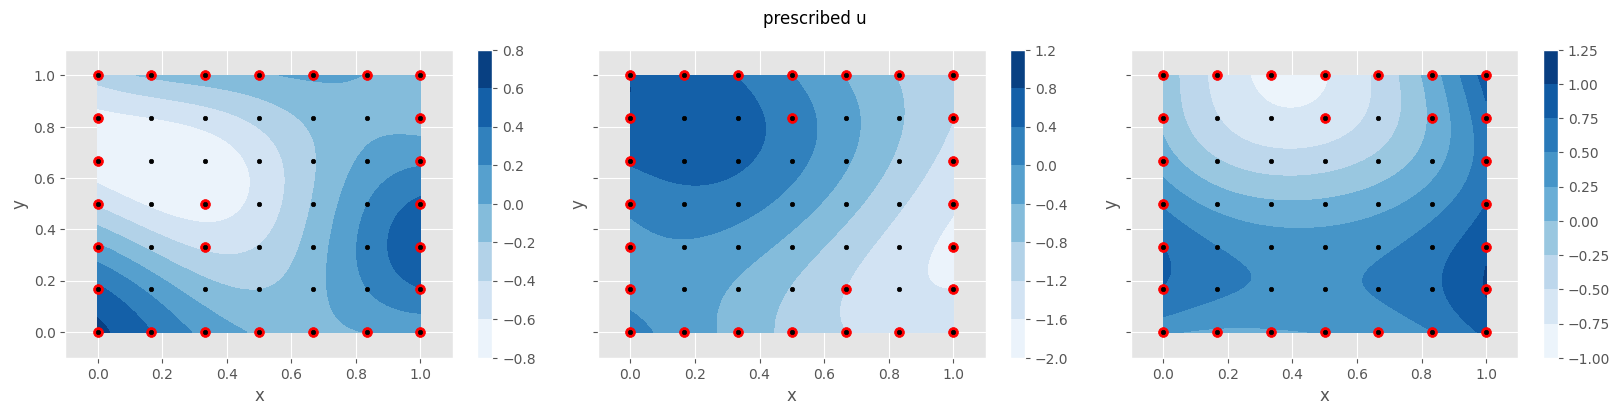

In [6]:
# Plot u's
plot_obs(xy_fine, xy_all, xy_obs, vmapped_u_true_functions, title = 'prescribed u')

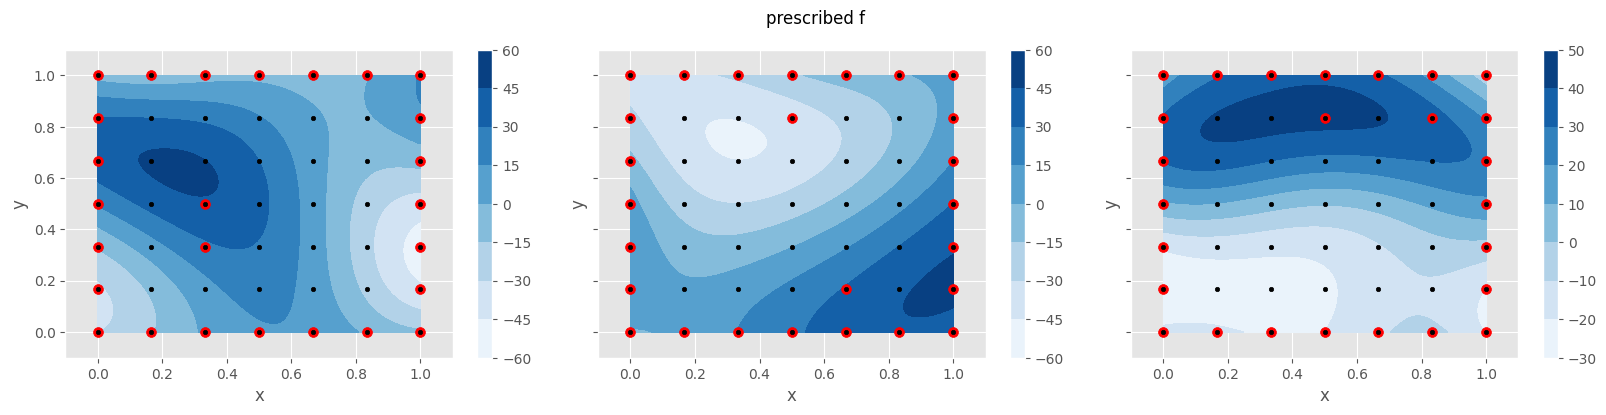

In [7]:
# Plot f's
plot_obs(xy_fine, xy_all, xy_obs, rhs_functions, title = 'prescribed f')

In [8]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [9]:
# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_models = tuple([CholInducedRKHS(
    xy_all[i],
    feature_operators,
    k_u
    ) for i in range(m)])

In [10]:
# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints

rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val)
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(
    model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])

In [11]:
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.4)

@vectorize_kfunc
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    
P_model = OperatorModel(k_P)

In [12]:
collocation_points = xy_ints
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
)

## Optimize

  0%|          | 0/301 [00:00<?, ?it/s]

Iteration 0, loss = 267.8, Jres = 460.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.14, Jres = 343.3, alpha = 2.083, improvement_ratio = 0.9664
Iteration 2, loss = 11.86, Jres = 468.9, alpha = 1.736, improvement_ratio = 0.9804
Iteration 3, loss = 7.312, Jres = 31.28, alpha = 1.447, improvement_ratio = 1.014
Iteration 4, loss = 5.355, Jres = 11.96, alpha = 1.206, improvement_ratio = 1.016
Iteration 5, loss = 4.205, Jres = 8.015, alpha = 1.005, improvement_ratio = 1.011
Iteration 100, loss = 3.551e-05, Jres = 0.02018, alpha = 1.783e-05, improvement_ratio = 0.7104
Iteration 200, loss = 1.1e-05, Jres = 8.822e-05, alpha = 8.333e-07, improvement_ratio = 0.9934
Iteration 300, loss = 1.101e-05, Jres = 4.677e-06, alpha = 8.333e-07, improvement_ratio = 0.9983


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.954158638218752e-07


/tmp/ipykernel_2579613/3029041811.py:17: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


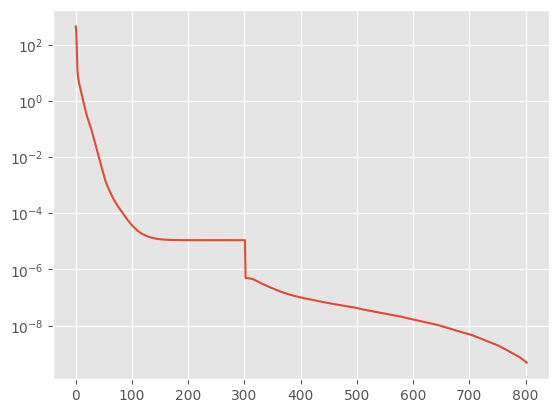

In [13]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])

params,convergence_data = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 301,
    init_alpha=3,
    line_search_increase_ratio=1.4,
    print_every = 100
)
p_adjusted,refine_convergence_data = adaptive_refine_solution(params,EqnModel,1e-3,500)
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

In [14]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))

Pre Refinement PDE MSE 2.0255267984924985e-08
Post Refinement PDE MSE 1.0814263527240678e-11


In [15]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)

u_sols = EqnModel.get_u_params(params)
P_sol = EqnModel.get_P_params(params)

## Measures of accuracy for u's

Results for u_1


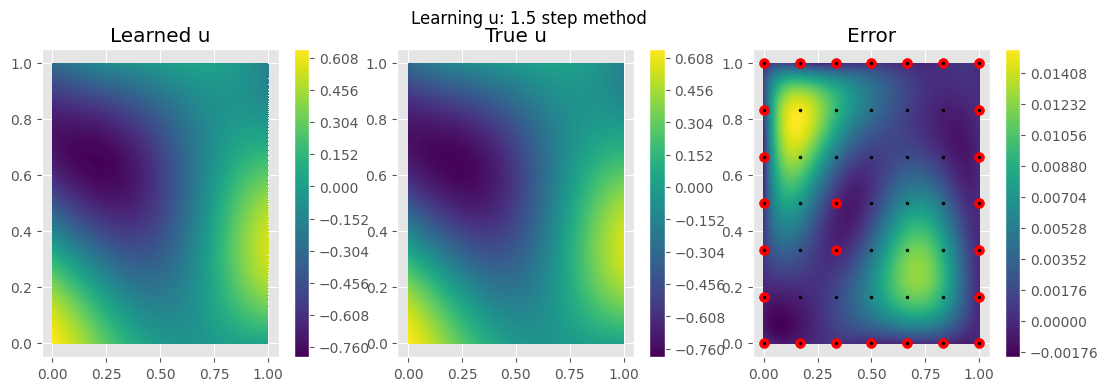

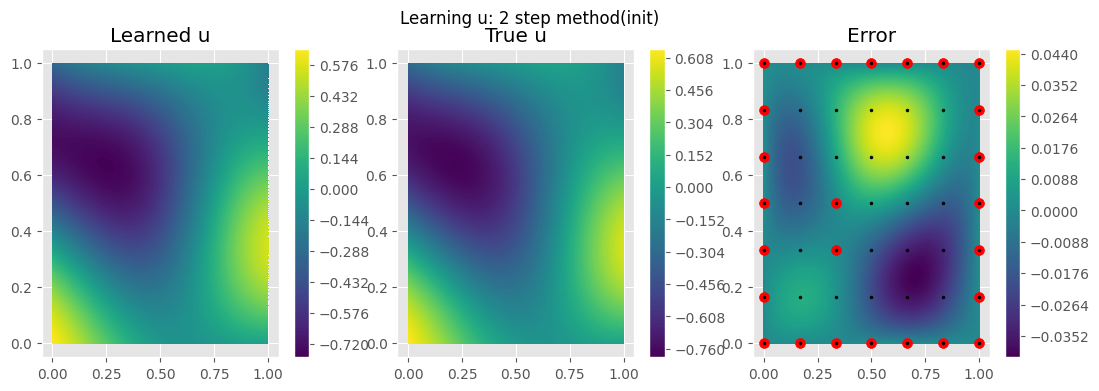

Results for u_2


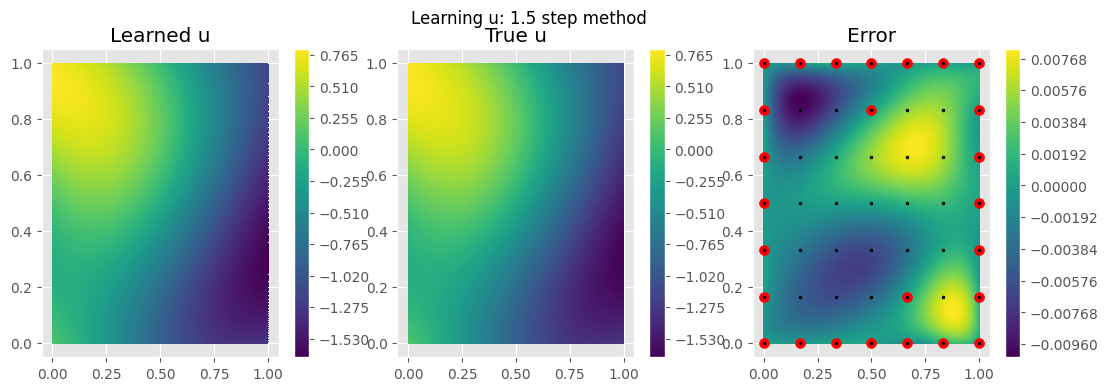

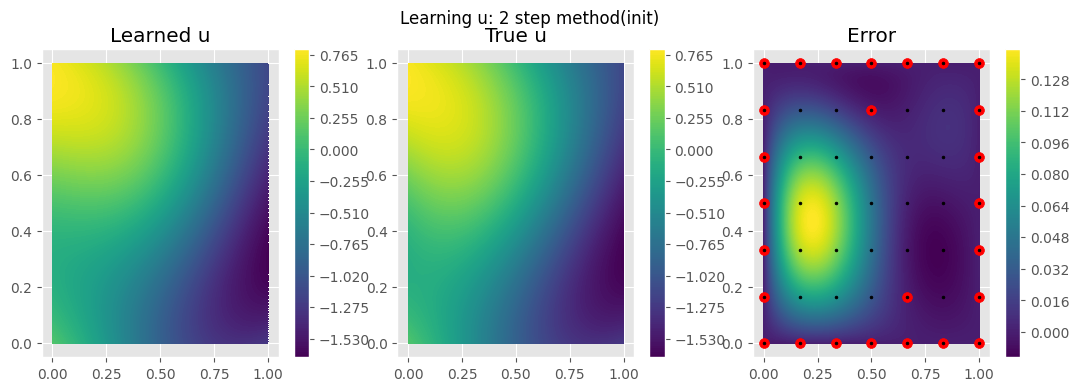

Results for u_3


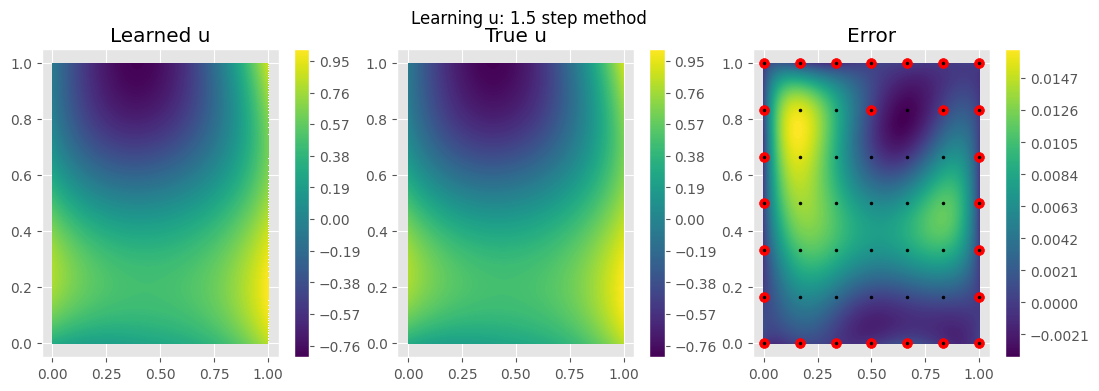

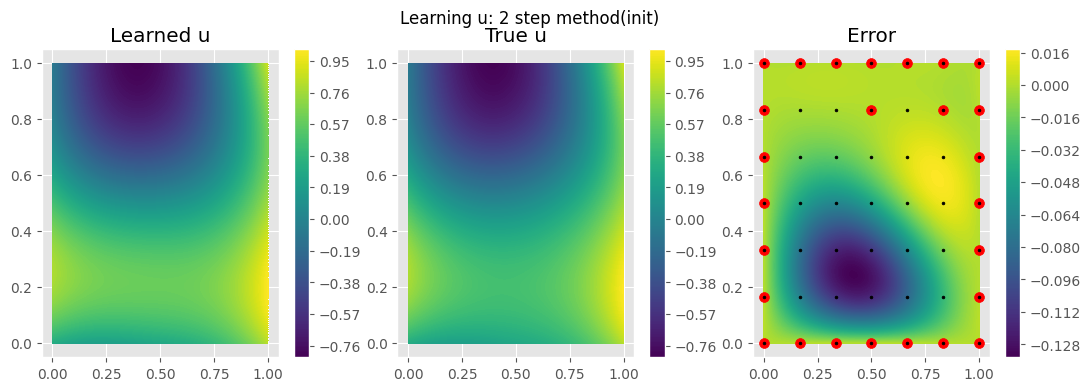

In [16]:
# Compare u's
# for i in range(len(u_true_functions)):
for i in range(3):
    print(f"Results for u_{i+1}")
    # Plot 
    plot_compare_error(xy_fine,
                       xy_all[i],
                       xy_obs[i],
                    lambda x:u_models[i].point_evaluate(x,u_sols[i]),
                    vmapped_u_true_functions[i]
                    , title = 'Learning u: 1.5 step method')
    plot_compare_error(xy_fine,
                       xy_all[i],
                       xy_obs[i],
                    lambda x:u_models[i].point_evaluate(x,all_u_params_init[i]),
                    vmapped_u_true_functions[i]
                    , title = 'Learning u: 2 step method(init)')

In [17]:
table_u_errors(
    xy_fine, u_models, u_sols, 
    vmapped_u_true_functions, 
    all_u_params_init)

,1 step,2 step (at initialization)
0,1.468867,4.673863
1,0.514341,6.278040
2,1.452214,10.197640
3,1.240343,2.442244
4,0.315711,10.011140
5,0.323929,3.347912
6,1.331207,4.487098
7,0.570294,2.198936
8,0.715493,3.427631
9,1.587827,5.367256


## Measures of accuracy for P

Auxiliar elements for evaluation

In [18]:
# Testing grid
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

# Estimated P from 1.5 step method
model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
S_train = model_grid_features_all
P_func = lambda x: P_model.predict_new(x,S_train,P_sol)

# Estimated P from 2 step method
init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
S_train_2 = init_P_features 
K = P_model.kernel_function(S_train_2,S_train_2)
P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
P_func2 = lambda x : P_model.predict_new(x,S_train_2,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):

    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features


    #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
    P_preds = P_func(S_test)
    return P_preds

### In sample error

In [19]:
# Error at m training functions

# Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
true = [f(xy_fine_int) for f in rhs_functions]

u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                  for ind in range(m)]
pred1_5 = [
    evaluate_hatP(
    P_func,
    u, xy_fine_int,feature_operators) for u in u_approx_funcs
]

twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                  for ind in range(m)]
pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
]
rmses1_5 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])
rmses2 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)])
print("Average error at training functions for 1.5 step: %", round(100*jnp.mean(rmses1_5),3))
print("Average error at training functions for 2 step: %", round(100*jnp.mean(rmses2),3))

Average error at training functions for 1.5 step: % 3.141
Average error at training functions for 2 step: % 27.994


### Out of distribution error

In [20]:
# Error at M testing functions
M = 50
kernel_GP = get_gaussianRBF(0.5)
# Sample M test functions from GP(0,K)
w_test_functions = GP_sampler(num_samples = M,
                kernel = kernel_GP,
                X = xy_pairs, 
                reg = 1e-12,
                seed = 2025
                )
vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

# mean 
true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
#pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
pred1_5 = [
    evaluate_hatP(
    lambda x:P_model.kernel_function(x,S_train)@P_sol,
    w, xy_fine_int,feature_operators) for w in w_test_functions
]

pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine_int,feature_operators) for u in w_test_functions
]

rmses1_5 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])
rmses2 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)])
print("Average error at testing functions for 1.5 step: %", round(100*jnp.mean(rmses1_5),2))
print("Average error at testing functions for 2 step: %", round(100*jnp.mean(rmses2),2))

Average error at testing functions for 1.5 step: % 8.91
Average error at testing functions for 2 step: % 44.03


### Operator learning error

We would like to test how good is the learned $\hat P$ in the following way:

1. Sample $f_{\text{new}}$
2. Compare $\hat P^{-1} (f_{\text{new}})$ vs. $P^{-1} (f_{\text{new}})$.

To set up a quick experiment we can prescribe a function 
$$
u_{\text{new}} \sim \mathcal{GP}(0,K)
$$
and then get 
$$
f_{\text{new}} = P(u_{\text{new}})\qquad \text{ where }P(\square) = \text{div}\left(A \nabla(\square)\right)
$$
so that we know that
$$
P^{-1}(f_{\text{new}}) = u_{\text{new}}.
$$
And all the efforts now are into computing 
$$
\hat P^{-1} (f_{\text{new}}).
$$

which in essence can be estimated from the current method since we only need to make sure to fix the ```equation_residual``` and just learn the parameters of ```u_new``` using the same LM method.



Let's do this for one function to see how well $u_{\text{new}}$ is recovered.

In [21]:
kernel_GP_new = get_gaussianRBF(0.5)
u_new = tuple(GP_sampler(num_samples = 1,
                                        X = xy_pairs, 
                                        kernel = kernel_GP_new,
                                        reg = 1e-12,
                                        seed = 2026
                                    ))
                                    
# vmap
vmap_u_new = jax.vmap(u_new[0]) # vmap'ed
rhs_new = jax.vmap(get_rhs_darcy(u_new[0])) #vmap'ed

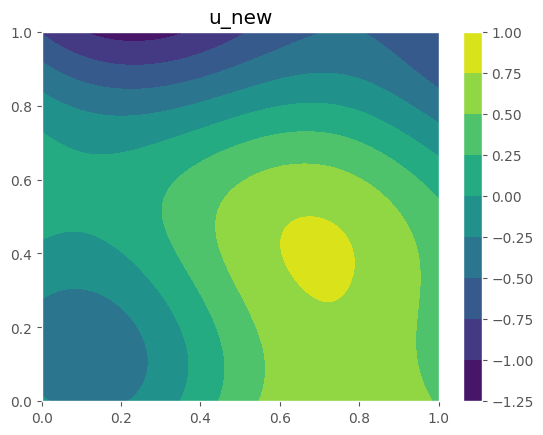

In [22]:
plt.tricontourf(*xy_fine.T,vmap_u_new(xy_fine))
plt.colorbar()
plt.title('u_new')
plt.show()

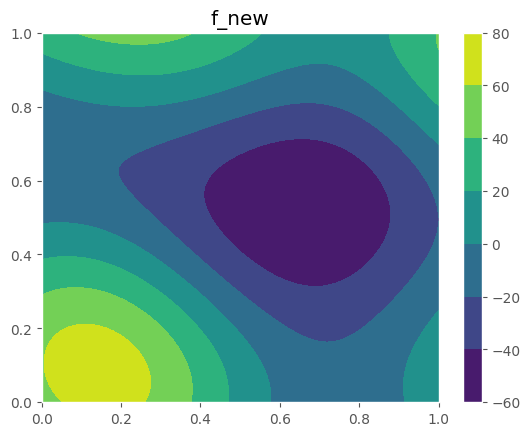

In [23]:
plt.tricontourf(*xy_fine.T,rhs_new(xy_fine))
plt.colorbar()
plt.title('f_new')
plt.show()

We now want to create a class `PDEModel` that imitates `OperatorModel` and fixes the learned parameters of $\hat P$ such that we can use the L-M solver

In [24]:
num_interior_points = 500
num_grid_points = 20
# Sample collocation points for learning u
xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(24)
    )
xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_interiors,xy_boundarys))

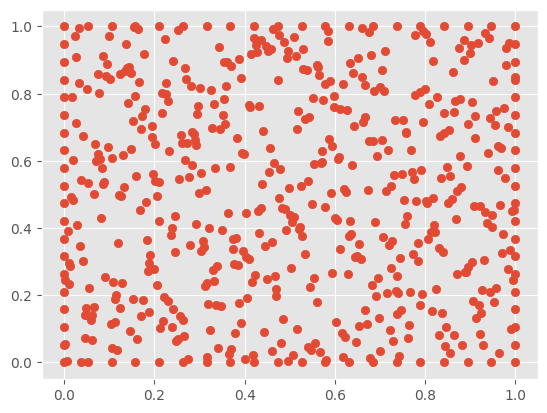

In [25]:
plt.scatter(*xy_all[0].T)

In [26]:
@jit
def get_pred_hatP(input_features):
    return P_model.predict_new(input_features,model_grid_features_all,P_sol)
#tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy]) gets replaced by xy_bdy[0]

xy_bdy = xy_boundarys[0]


# new_obs = new_u_true_function(tx_init_bdy)
new_obs = vmap_u_new(xy_bdy) # Boundary conditions values that need to be satisfied

# Need to create xy_all where I want to solve the pde. 
xy_all_ = xy_all[0]

# Object to capture learned solution
u_model = CholInducedRKHS(
    xy_all_,
    feature_operators,
    k_u
    )

xy_int = xy_interiors[0]


class PdeModel():
    datafit_weight = 50.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
        grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
        return jnp.hstack([xy_int,grid_features])
    
    # @jit
    # def get_grid_target(u_params):
    #     return u_model.evaluate_operators((dt_k,),xy_ints[0],u_params)
    
    @jit
    def get_grid_target(u_params):
        return rhs_new(xy_int)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(xy_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_hatP(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model.kmat+1e-5 * diagpart(u_model.kmat)

In [27]:
# new_u_init = 0*u_sol
new_u_init = jnp.zeros(xy_all_.shape[0]*len(feature_operators))

u_params_pde,pde_convergence_data = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 101,
    init_alpha=0.05,
    line_search_increase_ratio=1.4,
    print_every = 10
)
u_pde_adj,pde_refine_conv_data = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003721, Jres = 693.7, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 0.003243, Jres = 0.0001062, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 0.003066, Jres = 4.632e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.002947, Jres = 3.391e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.002852, Jres = 2.747e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.002768, Jres = 2.333e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.002421, Jres = 1.265e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.001703, Jres = 5.91e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0009154, Jres = 1.693e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.000837, Jres = 4.23e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0007886, Jres = 1.597e-07, alpha = 4.579e-06, improvement_ratio = 1.0
Iteration 60

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.001175281413027256
Converged


In [28]:
new_u_eval_fine = u_model.point_evaluate(xy_fine,u_pde_adj)

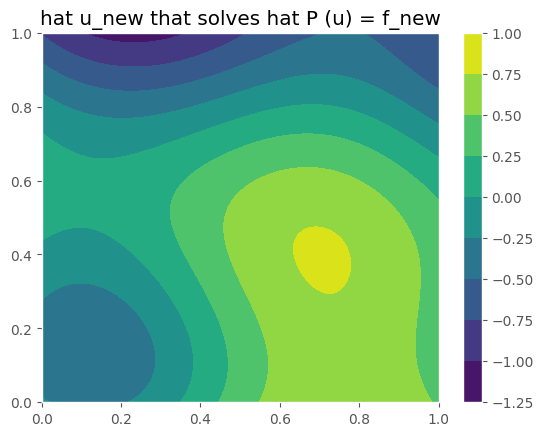

In [29]:
plt.tricontourf(*xy_fine.T,new_u_eval_fine)
plt.title('hat u_new that solves hat P (u) = f_new')
plt.colorbar()

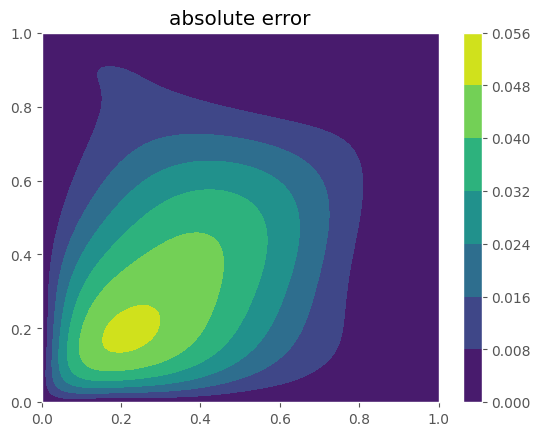

In [30]:
plt.tricontourf(*xy_fine.T,jnp.abs(vmap_u_new(xy_fine)-new_u_eval_fine))
plt.title('absolute error')
plt.colorbar() 
plt.show() 

- Convergence plot for the solver. DONE
- Compute 
$$
\mathbb{E}_{f\sim \mathcal{GP}(0,k)}\frac{\|\hat P^{-1}(f) - P^{-1}(f)\|_{L^2}^2}{\|P^{-1}(f)\|_{L^2}^2}
$$

- We should prescribe $f$.
- We could prescribe zero-boundary $u$ with the sine expansion.
- Histogram of the diference or ratio.
- Test 1.5 on one example first.

## Convergence

In [31]:
def error_of_solver(num_pts):
    # Sample points
    num_interior_points = int(num_pts)
    num_grid_points = num_pts//5
    # Sample collocation points for learning u
    xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
        num_functions = 1,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(24)
        )
    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_interiors,xy_boundarys))

    @jit
    def get_pred_hatP(input_features):
        return P_model.predict_new(input_features,model_grid_features_all,P_sol)
    #tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy]) gets replaced by xy_bdy[0]

    xy_bdy = xy_boundarys[0]

    xy_int = xy_interiors[0]

    # new_obs = new_u_true_function(tx_init_bdy)
    new_obs = vmap_u_new(xy_bdy) # Boundary conditions values that need to be satisfied

    # Need to create xy_all where I want to solve the pde. 
    xy_all_ = xy_all[0]

    # Object to capture learned solution
    u_model = CholInducedRKHS(
        xy_all_,
        feature_operators,
        k_u
        )

    

    
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
            grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
            return jnp.hstack([xy_int,grid_features])
        
        # @jit
        # def get_grid_target(u_params):
        #     return u_model.evaluate_operators((dt_k,),xy_ints[0],u_params)
        
        @jit
        def get_grid_target(u_params):
            return rhs_new(xy_int)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(xy_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_hatP(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        
    # Optimize
    new_u_init = jnp.zeros(xy_all_.shape[0]*len(feature_operators))

    u_params_pde,pde_convergence_data = LevenbergMarquadtMinimize(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        max_iter = 101,
        init_alpha=0.05,
        line_search_increase_ratio=1.4,
        print_every = 10
    )
    
    u_pde_adj,pde_refine_conv_data = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

    # pred
    pred = u_model.point_evaluate(xy_fine,u_pde_adj)

    # true
    true = vmap_u_new(xy_fine)

    # Error
    error = get_nrmse(true,pred)
    #error = jnp.linalg.norm(pred-true)

    print('error: ', error)

    return error

In [32]:
num_pts = [10,30,50,100,500,1000]
errors = [error_of_solver(n) for n in num_pts]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.849e-12, Jres = 839.4, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 3.683e-23, Jres = 8.916e-06, alpha = 0.03472, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.700919194559012e-23
Converged
error:  0.6347321530890425


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 1.677e-05, Jres = 662.9, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 1.874e-06, Jres = 2.685e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 2.816e-07, Jres = 4.572e-06, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 3.577e-08, Jres = 1.65e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 3.594e-09, Jres = 5.866e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.797e-10, Jres = 1.864e-07, alpha = 0.01674, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.9984434958558974e-14
Converged
error:  0.044049941814018355


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.00296, Jres = 651.9, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 0.002098, Jres = 0.0001308, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 0.001691, Jres = 5.745e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.001403, Jres = 4.248e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.001185, Jres = 3.482e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.001022, Jres = 2.866e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0006928, Jres = 1.01e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0003939, Jres = 3.752e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002334, Jres = 1.046e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001392, Jres = 3.399e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 7.301e-05, Jres = 1.83e-07, alpha = 4.579e-06, improvement_ratio = 1.0
Iteration 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 1.2661254653077613e-05
Converged
error:  0.04399324647506611


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003502, Jres = 711.6, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 0.002951, Jres = 0.000129, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 0.002817, Jres = 4.476e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.002736, Jres = 2.923e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.002671, Jres = 2.295e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.002611, Jres = 1.952e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.002315, Jres = 1.223e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.001506, Jres = 5.863e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0007102, Jres = 1.6e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0006323, Jres = 2.238e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.000588, Jres = 1.834e-07, alpha = 4.579e-06, improvement_ratio = 1.0
Iteration 60,

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.000942626601606507
Converged
error:  0.045965380272458806


2024-08-29 13:01:18.456481: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.547 = f64[896,896]{1,0} reduce(f64[896,896,2]{2,1,0} %broadcast.976, f64[] %constant.11), dimensions={2}, to_apply=%region_15.543, metadata={op_name="jit(k_super)/jit(main)/reduce_sum[axes=(2,)]" source_file="/home/juanfelipe/Desktop/research/keql/keql_tools/Kernels.py" source_line=37}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-29 13:01:18.977711: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.521330446s
Constant folding an instruction is taking > 1s:

  %re

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002768, Jres = 693.7, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 0.002349, Jres = 9.262e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 0.002191, Jres = 4.046e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.002087, Jres = 2.945e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.002005, Jres = 2.382e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.001933, Jres = 2.017e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.001653, Jres = 1.073e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.001079, Jres = 4.777e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.000599, Jres = 1.078e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0005554, Jres = 2.421e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0005183, Jres = 1.666e-07, alpha = 4.579e-06, improvement_ratio = 1.0
Iteration 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0006634587816655642
Converged
error:  0.04566555040881949


2024-08-29 13:02:35.175669: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %reduce.547 = f64[1796,1796]{1,0} reduce(f64[1796,1796,2]{2,1,0} %broadcast.976, f64[] %constant.11), dimensions={2}, to_apply=%region_15.543, metadata={op_name="jit(k_super)/jit(main)/reduce_sum[axes=(2,)]" source_file="/home/juanfelipe/Desktop/research/keql/keql_tools/Kernels.py" source_line=37}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-29 13:02:39.197648: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.022055081s
Constant folding an instruction is taking > 2s:

 

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002579, Jres = 677.1, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 0.002209, Jres = 8.195e-05, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 0.002074, Jres = 3.388e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.001988, Jres = 2.466e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.001919, Jres = 2.012e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.001859, Jres = 1.729e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.001602, Jres = 1.063e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.001028, Jres = 4.685e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0005777, Jres = 1.022e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0005251, Jres = 3.119e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0004847, Jres = 5.491e-07, alpha = 4.579e-06, improvement_ratio = 1.0
Iteration

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005707665620751009
Converged
error:  0.04565110093039332


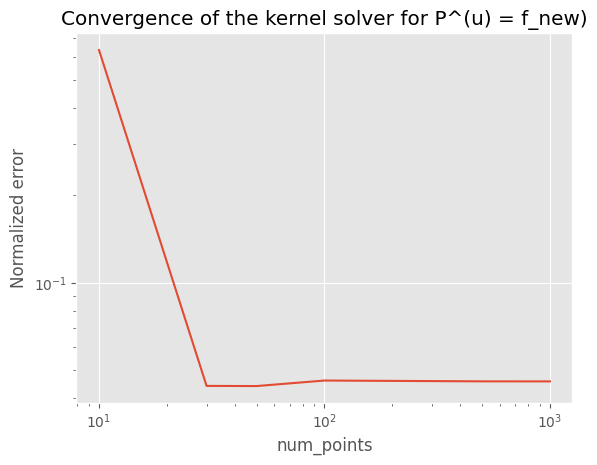

In [41]:
plt.loglog(num_pts,errors)
plt.title('Convergence of the kernel solver for P^(u) = f_new)')
plt.xlabel('num_points')
plt.ylabel('Normalized error')
plt.show()